# De Gregorio et al. (2021)<br/> **Lemur *Indri indri***

**Paper:** De Gregorio, C., Valente, D., Raimondi, T., Torti, V., Miaretsoa, L., Friard, O., Giacoma, C., Ravignani, A., & Gamba, M. (2021). Categorical rhythms in a singing primate. *Current Biology, 31*(20), R1379–R1380. DOI: [10.1016/j.cub.2021.09.032](https://doi.org/10.1016/j.cub.2021.09.032)

**Dataset:** Available from the first author upon request.

**Dataset license:** Unknown; the dataset has therefore not been included.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from rhythmplot import *

# Path to the original data file
from config import EXCLUDED_DATA_DIR # Wherever you store the excluded data
ORIGINAL_DATA_PATH = f'{EXCLUDED_DATA_DIR}/degregorio2021/De_Gregorio_et_al_DATA_intervals.csv'
# (Included) data directory 
DATA_DIR = '../data/degregorio2021'

# Function to save figures: you can easily toggle this on/off globally
savefig = get_figure_saver(group='degregorio2021', save_pdf=True, save_png=True)

## Preprocess data

Background from article:

"We focused on one of the few singing primates, the lemur Indri indri (Figure 1B), sampling approximately 1% of all living individuals from this critically endangered species (for details, see Supplemental information, published with this article online). All members of a family group sing in temporally coordinated duets and choruses (see: https://youtu.be/wxVYsAodZ6U)7,8. Over 12 years, we recorded songs from 20 indri groups (39 individuals) living in their natural habitat, the rainforest of Madagascar. We extracted temporal features of indris’ songs, analyzing inter-onset intervals (Fig"

From the supplements:

"We then labeled the silent portions of the individual contributions, differentiating silences depending on whether they occurred between two notes of the same phrase, vs. between two different phrases or two different isolated notes. For each of the above units and intervals, we extracted the timing of note onsets and duration usin Praat. We imported them in R (R Core Team 2017; version 3.4.3) and calculated the inter-onset intervals (tk, Figure 1C) based on onsets to evaluate the rhythmic structure of contributionsS11. Based on previous workS7,S12, we used the information on notes and silences type (belonging to a phrase or an isolated note) to calculate two types of tk. The within-phrase tk (WP: Within-Phrase inter-onset intervals) are all and only the intervals between notes within a phrase (roughly mapping to the two leftmost peaks in Figure 1E). The between-phrase tk (BP: Between-Phrase inter-onset intervals) are all and only the intervals between two different phrases or between two isolated notes (roughly mapping to the two rightmost peaks in Figure 1E). Note that a sequence of n notes will produce n-1 inter-onset intervals, i.e. t1,...,tn-1."

"We then calculated rhythmic ratios rk following the methodology of Roeske et al.S13, namely by dividing each tk for its duration plus the duration of the following interval: rk = tk /(tk+tk+1). Since each tk can either be a WP or a BP, we obtained four ratio types: WP/(WP+WP), WP/(WP+BP), BP/(WP+BP) and BP/(BP+BP), depending on the type of two adjacent tk."

In [2]:
# Load and clean up the dataframe
df = pd.read_csv(ORIGINAL_DATA_PATH, delimiter=';', decimal=",", index_col=0)
df.index.name = 'index'

# Labels are duplicated, drop those
# there's only one exception---maybe that's an error?
# I assume intra = 'witin phrase/WP' and inter = 'between phrase/BP'
assert len(df.query('label1=="intra-DP" and label2=="inter-DP"')) == 1
df['label'] = df['labelwp']
unique_labels = df[['label1', 'labelwp', 'label2', 'label3', 'label4', 'item_order']].drop_duplicates()
assert len(unique_labels) == 3
df.drop(columns=['label1', 'label2', 'label3', 'label4', 'item_order', 'labelwp'], inplace=True)

# Drop empty/constant columns
assert df['note_order'].isna().all()
assert df['item_notetype'].isna().all()
assert (df['age'] == 'Adult').all()
assert (df['age,class'] == 'Adult').all()
assert (df['exc_roar'] == 1).all()
assert (df['exc_intervals'] == 0).all()
df.drop(columns=['note_order', 'item_notetype', 'age,class', 'age', 'exc_roar', 'exc_intervals'], inplace=True)

# Rename some columns
df['name_individual'] = df['ID_Ind']
df['id_individual'] = df['id_singer']
df['num_intervals'] = df['n_of_intervals']
df.drop(columns=['ID_Ind', 'id_singer', 'n_of_intervals'])

# Save and then drop files
files = df[['file', 'id_phrase']].copy()
df.drop(columns=['file', 'id_phrase'], inplace=True)

# Singers
# `ID_ind` is presumably the name of the individual, which corresponds to `id_singer`. 
# Every singer has multiple contributions (`id_contribution`).
df['sex'] = df['sex'].map(dict(M='male', F='female'))
singers = (
    df[['name_individual', 'id_individual', 'sex']]
        .drop_duplicates()
        .reset_index()
        .drop(columns=['index'])
        .set_index('id_individual')
        .sort_index()
    )

# Songs have multiple contributors:
assert len(df['id_contribution'].unique()) > len(df['id_song'].unique())

# Check monotonicity
assert (df['X'].sort_values() == df['X']).all()

# Store the inter-onset intervals: the interval from each entry to the next one.
# We don't compute intervals across contributions, so the last row for a 
# contribution contains a NA value
intervals = []
for contrib_id in df['id_contribution'].unique():
    subset = df.query(f'id_contribution=={contrib_id}')
    assert len(subset['id_song'].unique()) == 1
    assert len(subset['id_individual'].unique()) == 1
    ints = subset['start'].values[1:] - subset['start'].values[:-1]
    intervals.extend(ints)
    intervals.append(np.nan)
df['interval'] = intervals

df = df.reindex(columns=[
    # Drop these columns, not sure what they contain:
    # 'X', # Monotonically increasing in any case
    # 'nu', 
    # 'order', # Initially more or less corresponds to X
    # 'num_intervals', # Does not correspond to #id_contribution or #id_song
    'start', 
    'duration',
    'interval',
    'label', # Either 'intra' or 'inter'
    'id_song',
    'id_group', # Corresponds to id_song
    'id_contribution', # Multiple per singer
    'id_individual', 
    'name_individual', 
    'sex', 
])

# Save data (excluded from repository)
# df.to_csv(f'{DATA_DIR}/degregorio2021-data.csv')
# save_intervals(df['interval'].values, 'degregorio2021', 'degregorio2021')

There are multiple singers (with a unique `id_singer`) contributing to each song (unique `song_id`). 
So if we take the `start` values for a single contribution (`id_contribution`), then we get sequence of vocalization onsets (their their durations are in the column `duration`). 
The types are then determined from the labels "intra` and "inter", which correspond to the within-phrase/WP and between-phrase/BP in the supplements.

In [3]:
# Sample
df.iloc[24:31, :]

,start,duration,interval,label,id_song,id_group,id_contribution,id_individual,name_individual,sex
index,,,,,,,,,,
25,83.340,5.165,6.158,inter,1,1,1,12,Bevolo,female
26,89.498,0.624,1.592,intra,1,1,1,12,Bevolo,female
27,91.090,0.774,2.226,intra,1,1,1,12,Bevolo,female
28,93.316,2.559,NaN,inter,1,1,1,12,Bevolo,female
36,20.608,0.987,2.415,intra,1,1,3,26,Jery,male
37,23.023,3.118,4.177,inter,1,1,3,26,Jery,male
38,27.200,1.083,2.178,intra,1,1,3,26,Jery,male


## Individual plots

In [4]:
# Note: these files are excluded from this repo
df = pd.read_csv(f'{DATA_DIR}/degregorio2021-data.csv')

# Replace rows where interval==NA with rows where everything is NA
df = separate_sequences(df[~df['interval'].isna()], 'id_contribution')
intervals = load_intervals('degregorio2021', 'degregorio2021')

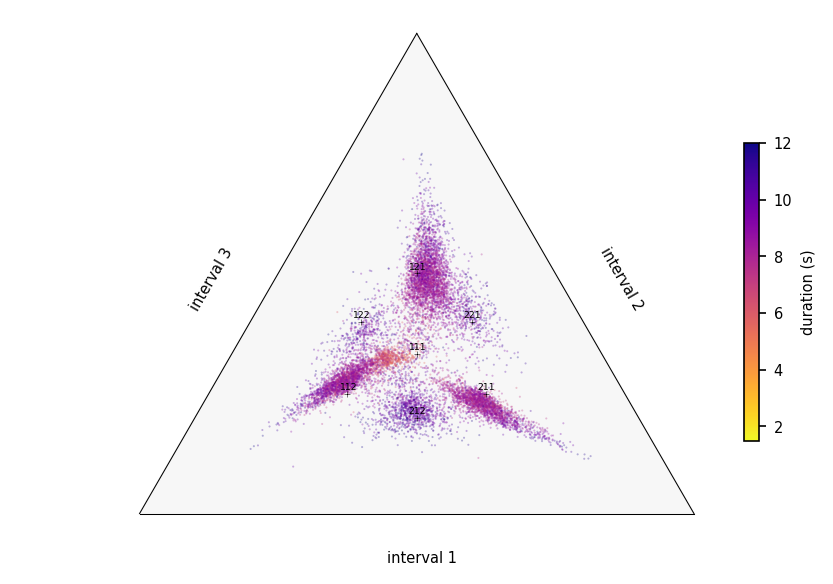

In [12]:
motifs, duration = normalize(ngram_motifs(intervals, length=3))
ternary_motif_plot(motifs, duration, min_dur=1.5, max_dur=12, 
    ratio_kws=dict(factors=[1, 2]), cbar_kws=dict(orientation='vertical'))
savefig('motifs')

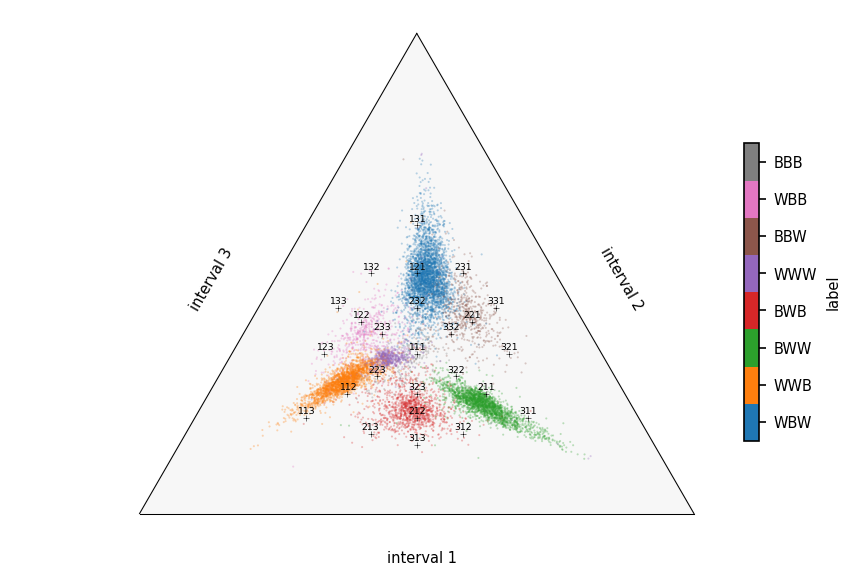

In [6]:
labels = string_motifs(
    separate_sequences(df, 'id_contribution')['label'], 
    length=3, 
    aggregator=dict(intra='W', inter='B'), sep='')
ternary_motif_plot(motifs, duration, min_dur=1.5, max_dur=12, labels=labels)
savefig('motifs-by-type', dpi=300)

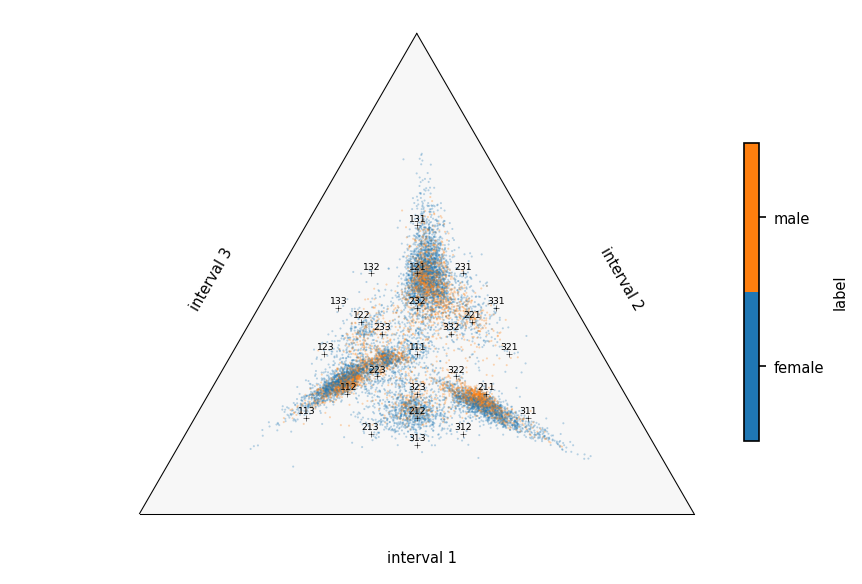

In [7]:
labels = string_motifs(df['sex'], length=3, aggregator=lambda motif: motif[0])
ternary_motif_plot(motifs, duration, labels=labels, min_dur=1.5, max_dur=12)
savefig('motifs-by-sex')

## Combined plots

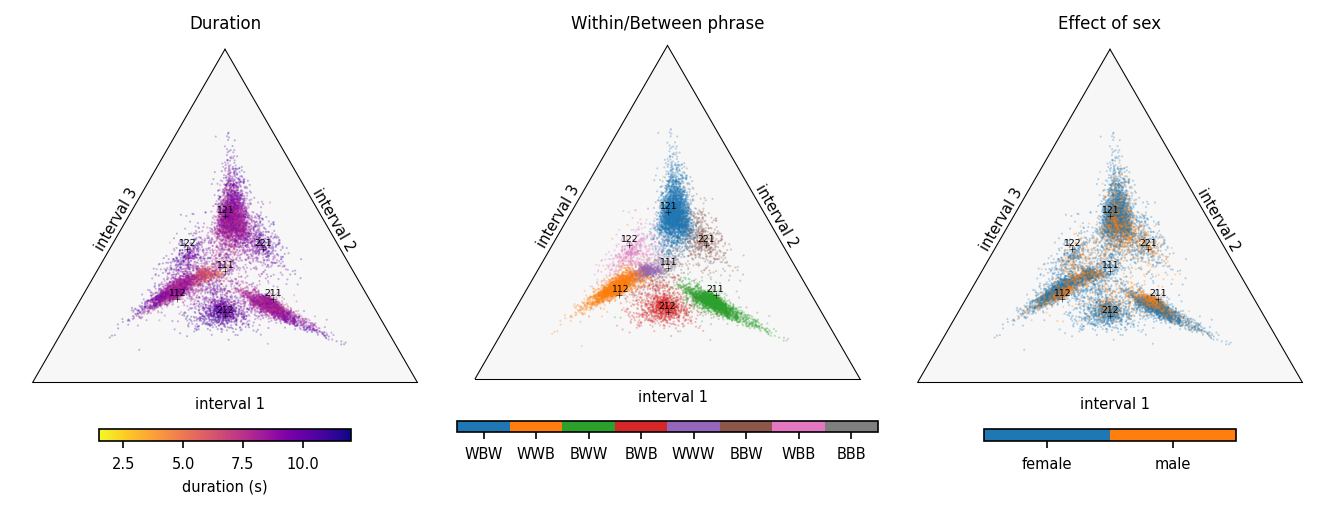

In [8]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9, 3.5), tight_layout=True)
kws = dict(min_dur=1.5, max_dur=12, 
    ratio_kws=dict(factors=[1,2]), 
    plot_kws=dict(bottom_label_offset=-.05))

motifs, duration = normalize(ngram_motifs(intervals, length=3))
ternary_motif_plot(motifs, duration, ax=ax0, **kws)
ax0.set_title('Duration', fontsize=8)

labels = string_motifs(
    separate_sequences(df, 'id_contribution')['label'], 
    length=3, 
    aggregator=dict(intra='W', inter='B'), sep='')
ternary_motif_plot(motifs, duration, labels=labels, ax=ax1,
    cbar_kws=dict(orientation='horizontal', fraction=.05, aspect=40, label=''), **kws)
ax1.set_title('Within/Between phrase', fontsize=8)

labels = string_motifs(df['sex'], length=3, aggregator=lambda motif: motif[0])
ternary_motif_plot(motifs, duration, labels=labels, ax=ax2, 
    cbar_kws=dict(orientation='horizontal', label=''), **kws)
ax2.set_title('Effect of sex', fontsize=8)

savefig('overview')

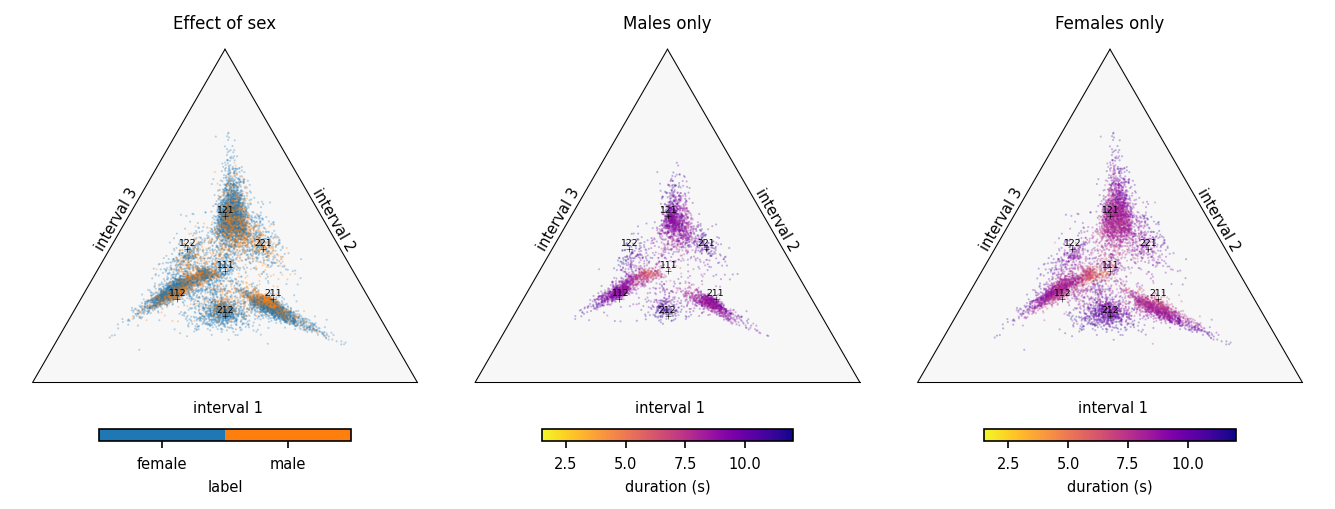

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9, 3.5), tight_layout=True)
kws = dict(min_dur=1.5, max_dur=12, ratio_kws=dict(factors=[1,2]))

motifs, duration = normalize(ngram_motifs(intervals, length=3))
labels = string_motifs(df['sex'], length=3, aggregator=lambda motif: motif[0])
ternary_motif_plot(motifs, duration, labels=labels, ax=ax0, 
    cbar_kws=dict(orientation='horizontal'), **kws)
ax0.set_title('Effect of sex', fontsize=8)

subset = separate_sequences(df.query('sex=="male"'), 'id_contribution')
motifs, duration = normalize(ngram_motifs(subset['interval'], length=3))
ternary_motif_plot(motifs, duration, ax=ax1, **kws)
ax1.set_title('Males only', fontsize=8)

subset = separate_sequences(df.query('sex=="female"'), 'id_contribution')
motifs, duration = normalize(ngram_motifs(subset['interval'], length=3))
ternary_motif_plot(motifs, duration, ax=ax2, **kws)
ax2.set_title('Females only', fontsize=8)

savefig('effect-of-sex')

## Interval types

Text(0.5, 1.0, 'Within- and between-phrase intervals')

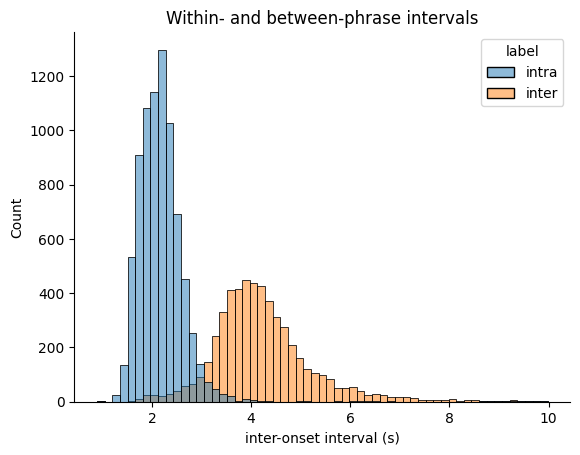

In [10]:
import seaborn as sns
sns.histplot(
    data=df.query('interval > 0 and interval < 10'),
    x='interval', hue='label',
)
sns.despine()
plt.xlabel('inter-onset interval (s)')
plt.title('Within- and between-phrase intervals')

<AxesSubplot:xlabel='interval', ylabel='Count'>

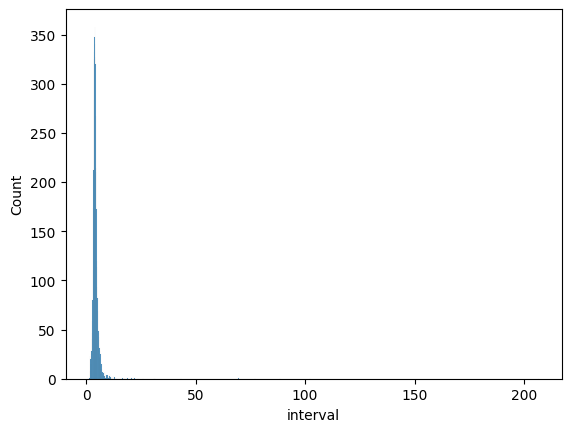

In [11]:
sns.histplot(df.query('label=="inter"')['interval'])